<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Causal-Inference" data-toc-modified-id="Causal-Inference-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Causal Inference</a></span><ul class="toc-item"><li><span><a href="#The-Definition-of-Causal-Effect" data-toc-modified-id="The-Definition-of-Causal-Effect-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>The Definition of Causal Effect</a></span></li><li><span><a href="#Assumptions-of-Estimating-Causal-Effect" data-toc-modified-id="Assumptions-of-Estimating-Causal-Effect-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Assumptions of Estimating Causal Effect</a></span></li><li><span><a href="#Confounders" data-toc-modified-id="Confounders-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Confounders</a></span></li><li><span><a href="#Randomized-Trials-v.s.-Observational-Studies" data-toc-modified-id="Randomized-Trials-v.s.-Observational-Studies-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Randomized Trials v.s. Observational Studies</a></span></li><li><span><a href="#Matching" data-toc-modified-id="Matching-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Matching</a></span><ul class="toc-item"><li><span><a href="#Propensity-Scores" data-toc-modified-id="Propensity-Scores-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Propensity Scores</a></span></li></ul></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Implementation</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))

from formats import load_style
load_style(plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

%watermark -a 'Ethen' -d -t -v -p numpy,scipy,pandas,sklearn,matplotlib,seaborn

Ethen 2019-04-22 21:02:05 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.2
scipy 1.0.1
pandas 0.23.4
sklearn 0.20.2
matplotlib 2.2.3
seaborn 0.9.0


# Causal Inference

A typical statement that people make in the real world follows a pattern like this:

> I took ibuprofen and my headache is gone, therefore the medicine worked.

Upon seeing this statement, we may be tempted to view the statement above as a causal effect, where ibuprofen does in fact help with headache. The statement, however, does not tell us what would have happened if the person didn't take the medicine. Maybe headache would have been cured without taking the medicine.

We'll take a moment and introduce some notation to formalize the discussion of causal inferencing. We denote $Y^a$ as the outcome that would have been observed if treatment was set to $A = a$. In the context of causal inferencing, there are two possible actions that can be applied to an individual. $1$, treatment; $0$, control. Hence $Y^1$ denotes the outcome if the treatment was applied, whereas $Y^0$ measures the outcome if individual was under the control group.

Coming back to the statement above. The reason why it isn't a proper causal effect is because it's only telling us $Y^1=1$. It doesn't tell us what would have happened had we not taken ibuprofen, $Y^0=?$. And we can only state that there is a causal effect if $Y^1 \neq Y^0$.

The two main messages that we're getting at in the section above are:

First, in the context of causal inferencing, a lot of times we're mainly interested in the relationship between means of different potential outcomes. 

\begin{align}
E(Y^1 - Y^0)
\end{align}

Where the term, **potential outcome, refers to the outcome we would see under each possible treatment option**. More on this formula in the next section.

Second, our little statement above shows what is known as the **fundamental problem of causal inferencing**. Meaning we can only observe one potential outcome for each person. However, with certain assumptions, we can estimate population level causal effects. In other words, it is possible for us to answer questions such as: what would the rate of headache remission be if everyone took ibuprofen when they had a headache versus if no one did.

Thus the next question is, how do we use observed data to link observed outcome to potential outcome.

## The Definition of Causal Effect

In the previous section, we flashed the idea that with causal inferencing, we're interesting in estimating $E(Y^1 - Y^0)$. This notation denotes **average causal effect**. What this means is:  

Imagine a hypothetical world where our entire population received treatment $A=0$. Versus, some other hypothetical world where everyone received the other treatment, $A=1$. The most important thing here is the two hypothetical world should have the exact same population. The only difference is the difference in our treatment. If we were able to observe both of these worlds simultaneously, we could collect the outcome data from everyone in the populations, and then compute average difference.

This is what we mean by an average causal effect. It's computed over the whole population and we're saying, what would the average outcome be if everybody received one treatment, versus if everybody received another treatment. Of course, in reality, we're not going to see both of these worlds, but this is what we're hoping to estimate.

In reality, what we get from an experiment is $E(Y|A=1)$. Here, we are saying what is the expected value of $Y$ given $A=1$. An equivalent way of reading this is the expected value of $Y$ restricting to the sub-population who actually had $A=1$. The main point that we're getting at is:

\begin{align}
E(Y^1 - Y^0) \neq E(Y|A=1) - E(Y|A=0)
\end{align}

The reason being the sub-population might differ from the whole population in important ways. e.g. People at higher risk for the flu might be more likely to get the flu shot. Then if we take the expected value of $Y$ among people who actually got the flu shot, we're taking expected value of $Y$ among a higher risk population. And this will most likely be different than the expected value of the potential outcome $Y^1$ because $Y^1$ is the outcome if everyone in the whole population got treatment, i.e. it's not restricting to a sub-population.

We could of course still compute $E(Y|A=1) - E(Y|A=0)$, but we need to keep in mind that the people who received treatment $A=0$ might differ in fundamental ways from people who got treatment $A=1$. So we haven't isolated a treatment effect, because these are different people, and they might have different characteristics in general. So that's why this distinction between the two are very important. The causal effect where we're manipulating treatment on the same group of people versus what we actually observe, which is the difference in means among some populations that are defined by treatment.

In short, the take home message from this paragraph is that $E(Y|A=1) - E(Y|A=0)$ is generally not a causal effect, because it is comparing two different populations of people.

## Assumptions of Estimating Causal Effect

Hopefully, by now, we know the fundamental problem of causal inferencing is that we can only observe one treatment and one outcome for each person at a given point in time. The next question is how do we then use observed data to link observed outcomes to potential outcomes? To do so, we'll need make some assumptions.

Our observed data typically consists of an outcome, $Y$, a treatment variable $A$, and then some set of covariates $X$ (additional information that we may wish to collect for individuals in the studies). The assumptions that we'll make are listed below.

- **Stable Unit Treatment Value Assumption (SUTVA):** Not interference between units. Treatment assignment of one unit does not affect the outcome of another unit. Same sentence but phrased a bit differently: When we assign somebody a treatment how effective that is isn't dependent on what is happening with other people
- **Positivity Assumption:** For every set of values for $X$, treatment assignment was not deterministic: $P(A=a|X=x) > 0$ for all $a$ and $x$. This assumption ensures we can have some data at every level of $X$ for people who are treated and not treated. The reason we need this assumption is: if for a given value of $X$, everybody would/wouldn't treated, then there's really no way for us to learn what would've happened if they were/weren't treated. In some cases where people with certain diseases might be ineligible for a particular treatment, we wouldn't want to make inference about that population, so we would probably exclude them from the study.
- **Ignorability Assumption:** Given pre-treatment covariates $X$, treatment assignment is independent of the potential outcome. $Y^1, Y^0 \perp A | X$ (here, $\perp$ denotes independence). So among people with the same values of $X$, we could essentially think of treatment as being randomly assigned. This is also referred to as "no unmeasured confounders' assumption".
- **Consistency Assumption:** The potential outcome under the treatment $A=a$, $Y^a$ is equivalent to the observed outcome $Y$, if the actual treatment received is $A=a$. i.e. $Y = Y^a \text{ if } A=a$.

Given the assumptions above, we can link our observe data to potential outcomes. Given that we have:

\begin{align}
E(Y | A=a, X=x)
&= E(Y^a | A=a, X=x) \text{ due to consistency} \\ 
&= E(Y^a | X=x) \text{ due to ignorability}
\end{align}

To elaborate on the ignorability assumption, the assumption said that conditional on the set of covariates $X$, the treatment assignment mechanism doesn't matter, it's just random. So, in other words, conditioning on $A$ isn't providing us any additional information about the mean of the potential outcome here.

After laying down the assumptions behind causal inferencing, we'll also introduce two important concepts **confounders** and **observational studies**.

## Confounders

Confounders are defined as variables that affect both the treatment and outcome. e.g. Imagine that older people are at higher risk of cardiovascular disease (the outcome), but are also more likely to receive statins (the treatment). In this case, age would be a confounder. Age is affecting both the treatment decision, which here is whether or not to receive statins, and is also directly affecting the outcome, which is cardiovascular disease. So, when it comes to confounder control, we are interested in first identifying a set of variables $X$ that will make the ignorability assumption hold. After finding a set of variables like this, will we then have hope of estimating causal effects.

## Randomized Trials v.s. Observational Studies

In a randomized trial, the treatment assignment, $A$, would be randomly decided. Thus if the randomized trial is actually randomized, the distribution of our covariates, $X$, will be the same in both groups. i.e. the covariates are said to be balanced. Thus if our outcome between different treatment groups end up differing, it will not be because of differences in $X$.

So you might be wondering, why not just always perform a randomized trial. Well, there are a couple of reasons:

- It's expensive. We have to enroll people into a trial, there might be loads to protocols that we need to follow and it takes time and money to keep track of those people after they enrolled.
- Sometimes it's unethical to randomize treatment. A typical example would be smoking.

For observational studies, though similar to a randomized trial, we're not actually intervening with the treatment assignment. We're only observing what happens in reality. Additionally, we can alway leverage retrospective data, where these data are already being collected for various other purposes not specific to this research that we're interested. Caveat is that these data might be messy and of lower quality.

Observational studies are becoming more and more prevalent, but as it is not a randomized trial, typically, the distribution of the confounders that we are concerned about, will differ between the treatment groups. The next section will describe matching, which is a technique that aims to address this issue.

## Matching

Matching is a method that attempts to control for confounding and make an observational study more like a randomized trial. The main idea is to match individuals in the treated group $A=1$ to similar individuals in the control group $A=0$ on the covariates $X$. This is similar to the notion of estimating the causal effect of the treatment on the treated.

e.g. Say there is only 1 covariate that we care about, age. Then, in a randomized trial, for any particular age, there should be about the same number of treated and untreated people. In the cases where older people are more likely to get $A=1$, if we were to match treated people to control people of the same age, there will be about the same number of treated and controls at any age.

Once the data are matched, we can treat it as if it was a randomized trial. The advantage of this approach is that it can help reveal lack of overlap in covariate distribution.

Caveat is that we can't exactly match on the full set of covariates, so what we'll do is try and make sure the distribution of covariates is balanced between the groups, also referred to as stochastic balance (The distribution of confounders being similar for treated and untreated subjects).

### Propensity Scores

We've stated during the matching procedure, each test group member is paired with a similar member of the control group. Here we'll elaborate on what we mean by "similar". Similarity is often times computed using **propensity scores**, which is defined as the probability of receiving treatment, rather than control, given covariates $X$.

We'll define $A=1$ for treatment and $A=0$ for control. The propensity score for subject $i$ is denoted as $\pi_i$.

\begin{align}
\pi_i = P(A=1 | X_i)
\end{align}

As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they'll receive the treatment. We can calculate this score by fitting our favorite classification algorithm to our data (input features are our covariates, and the labels are whether that person belongs to the treatment or control group).

With these knowledge in mind, let's get our hands dirty with some code, we'll discuss more as we go along.

## Implementation

We'll be using the [Right Heart Catheterization dataset](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.html). The csv file can be downloaded from the following [link](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/rhc.csv).

In [3]:
# we'll only be working with a subset of the variables in the raw dataset,
# feel free to experiment with more
AGE = 'age'
MEANBP1 = 'meanbp1'
CAT1 = 'cat1'
SEX = 'sex'
DEATH = 'death' # outcome variable in the our raw data
SWANG1 = 'swang1' # treatment variable in our raw data
TREATMENT = 'treatment'

num_cols = [AGE, MEANBP1]
cat_cols = [CAT1, SEX, DEATH, SWANG1]

input_path = 'rhc.csv'
dtype = {col: 'category' for col in cat_cols}
df = pd.read_csv(input_path, usecols=num_cols + cat_cols, dtype=dtype)
print(df.shape)
df.head()

(5735, 6)


,cat1,death,age,sex,meanbp1,swang1
0,COPD,No,70.25098,Male,41.0,No RHC
1,MOSF w/Sepsis,Yes,78.17896,Female,63.0,RHC
2,MOSF w/Malignancy,No,46.09198,Female,57.0,RHC
3,ARF,Yes,75.33197,Female,55.0,No RHC
4,MOSF w/Sepsis,Yes,67.90997,Male,65.0,RHC


Usually, our treatment group will be smaller than the control group.

In [4]:
# replace this column with treatment yes or no
df[SWANG1].value_counts()

No RHC    3551
RHC       2184
Name: swang1, dtype: int64

In [5]:
# replace these values with shorter names
df[CAT1].value_counts()

ARF                  2490
MOSF w/Sepsis        1227
COPD                  457
CHF                   456
Coma                  436
MOSF w/Malignancy     399
Cirrhosis             224
Lung Cancer            39
Colon Cancer            7
Name: cat1, dtype: int64

In [6]:
cat1_col_mapping = {
    'ARF': 'arf',
    'MOSF w/Sepsis': 'mosf_sepsis',
    'COPD': 'copd',
    'CHF': 'chf',
    'Coma': 'coma',
    'MOSF w/Malignancy': 'mosf',
    'Cirrhosis': 'cirrhosis',
    'Lung Cancer': 'lung_cancer',
    'Colon Cancer': 'colon_cancer'
}
df[CAT1] = df[CAT1].replace(cat1_col_mapping)

# convert features' value to numerical value, and store the
# numerical value to the original value mapping
col_mappings = {}
for col in (DEATH, SWANG1, SEX):
    col_mapping = dict(enumerate(df[col].cat.categories))
    col_mappings[col] = col_mapping
print(col_mappings)

for col in (DEATH, SWANG1, SEX):
    df[col] = df[col].cat.codes

df = df.rename({SWANG1: TREATMENT}, axis=1)
df.head()

{'death': {0: 'No', 1: 'Yes'}, 'swang1': {0: 'No RHC', 1: 'RHC'}, 'sex': {0: 'Female', 1: 'Male'}}


,cat1,death,age,sex,meanbp1,treatment
0,copd,0,70.25098,1,41.0,0
1,mosf_sepsis,1,78.17896,0,63.0,1
2,mosf,0,46.09198,0,57.0,1
3,arf,1,75.33197,0,55.0,0
4,mosf_sepsis,1,67.90997,1,65.0,1


In [7]:
cat_cols = [CAT1]
df_one_hot = pd.get_dummies(df[cat_cols], drop_first=True)
df_cleaned = pd.concat([df[num_cols], df_one_hot, df[[SEX, TREATMENT, DEATH]]], axis=1)
df_cleaned.head()

,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
0,70.25098,41.0,0,0,0,0,1,0,0,0,1,0,0
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
3,75.33197,55.0,0,0,0,0,0,0,0,0,0,0,1
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1


Given all of these covariates and our column `treatment` that indicates whether the subject received the treatment or control, we wish to have a quantitative way of measuring whether our covariates are balanced between the two groups.

To assess whether balance has been achieved, we can look at standardized mean differences (smd), which is calculated by the difference in the means between the two groups divided by the pooled standard deviation.

\begin{align}
smd = \frac{\bar{X}_t - \bar{X}_c}{\sqrt{(s^2_t + s^2_c) / 2}}
\end{align}

Where:

- $\bar{X}_t$, $\bar{X}_c$ denotes the mean of that feature for the treatment and control group respectively. Note that people often times report the absolute value of this number.
- $s^2_t$, $s^2_c$ denotes the standard deviation of that feature for the treatment and control group respectively. For the denominator we're essentially calculating the pooled standard deviation.

We can calculate the standardized mean differences for every feature. If our calculated smd is 1, then that means there's a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. After computing this measurement for all of our features, there is a rule of thumb that are commonly used to determine whether that feature is balanced or not, (similar to the 0.05 for p-value idea).

- Smaller than $0.1$. For a randomized trial, the smd between all of the covariates should typically fall into this bucket.
- $0.1$ - $0.2$. Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose smd fall under this range.
- $0.2$. Values that are greater than this threshold are considered seriously imbalanced.

In [8]:
features = df_cleaned.columns.tolist()
features.remove(TREATMENT)
features.remove(DEATH)
agg_operations = {TREATMENT: 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features
})

table_one = df_cleaned.groupby(TREATMENT).agg(agg_operations)
# merge MultiIndex columns together into 1 level
# table_one.columns = ['_'.join(col) for col in table_one.columns.values]
table_one.head()

treatment        age               meanbp1             cat1_chf  \
              count       mean        std       mean        std      mean   
treatment                                                                   
0              3551  61.760926  17.287674  84.868629  38.874134  0.069558   
1              2184  60.749836  15.630698  68.197802  34.242209  0.095696   

                    cat1_cirrhosis           cat1_colon_cancer    ...     \
                std           mean       std              mean    ...      
treatment                                                         ...      
0          0.254436       0.049282  0.216486          0.001690    ...      
1          0.294241       0.022436  0.148130          0.000458    ...      

          cat1_copd           cat1_lung_cancer           cat1_mosf            \
               mean       std             mean       std      mean       std   
treatment                                                                      
0          0.112363  0.315857         0.009575  0.097395  0.067868  0.251555   
1          0.026557  0.160821         0.002289  0.047804  0.072344  0.259117   

          cat1_mosf_sepsis                 sex            
                      mean       std      mean       std  
treatment                                                 
0                 0.148409  0.355555  0.539003  0.498547  
1                 0.320513  0.466781  0.585165  0.492806  

[2 rows x 23 columns]

In [9]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})


table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,age,0.0614
1,meanbp1,0.4551
2,cat1_chf,0.0950
3,cat1_cirrhosis,0.1447
4,cat1_colon_cancer,0.0376
5,cat1_coma,0.2073
6,cat1_copd,0.3424
7,cat1_lung_cancer,0.0950
8,cat1_mosf,0.0175
9,cat1_mosf_sepsis,0.4148


The next few code chunk will actually fit the propensity score.

In [10]:
# treatment will be our label for estimating the propensity score,
# and death is the outcome that we care about, thus is also removed
# from the step that is estimating the propensity score
death = df_cleaned[DEATH]
treatment = df_cleaned[TREATMENT]
df_cleaned = df_cleaned.drop([DEATH, TREATMENT], axis=1)

column_transformer = ColumnTransformer(
    [('numerical', StandardScaler(), num_cols)],
    sparse_threshold=0,
    remainder='passthrough'
)
data = column_transformer.fit_transform(df_cleaned)
data.shape

(5735, 11)

In [11]:
logistic = LogisticRegression(solver='liblinear')
logistic.fit(data, treatment)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
pscore = logistic.predict_proba(data)[:, 1]
pscore

array([0.20154141, 0.55090923, 0.40984646, ..., 0.17665103, 0.18749964,
       0.22041193])

In [13]:
roc_auc_score(treatment, pscore)

0.6903390599356525

We won't be spending too much time tweaking the model here, checking some evaluation metric of the model serves as a quick sanity check.

Once the propensity score is estimated, it is useful to look for overlap before jumping straight to the matching process. By overlap, we are referring to compare the distribution of the propensity score for the subjects in the control and treatment group.

In [14]:
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (2184,)
control count: (3551,)


Looking at the plot below, we can see that our features, $X$, does in fact contain information about the user receiving treatment. The distributional difference between the propensity scores for the two group justifies the need for matching, since they are not directly comparable otherwise.

Although, there's a distributional difference in the density plot, but in this case, what we see is that there's overlap everywhere, so this is actually the kind of plot we would like to see if we're going to do propensity score matching. What we mean by overlap is that no matter where we look on the plot, even though there might be more control than treatment or vice versa, there will still be some subject from either group. The notion of overlap means that our positivity assumption is probably reasonable. Remember positivity refers to the situation where all of the subjects in the study have at least some chance of receiving either treatment. And that appears to be the case here, hence this would be a situation where we would feel comfortable to proceed with our propensity score matching.

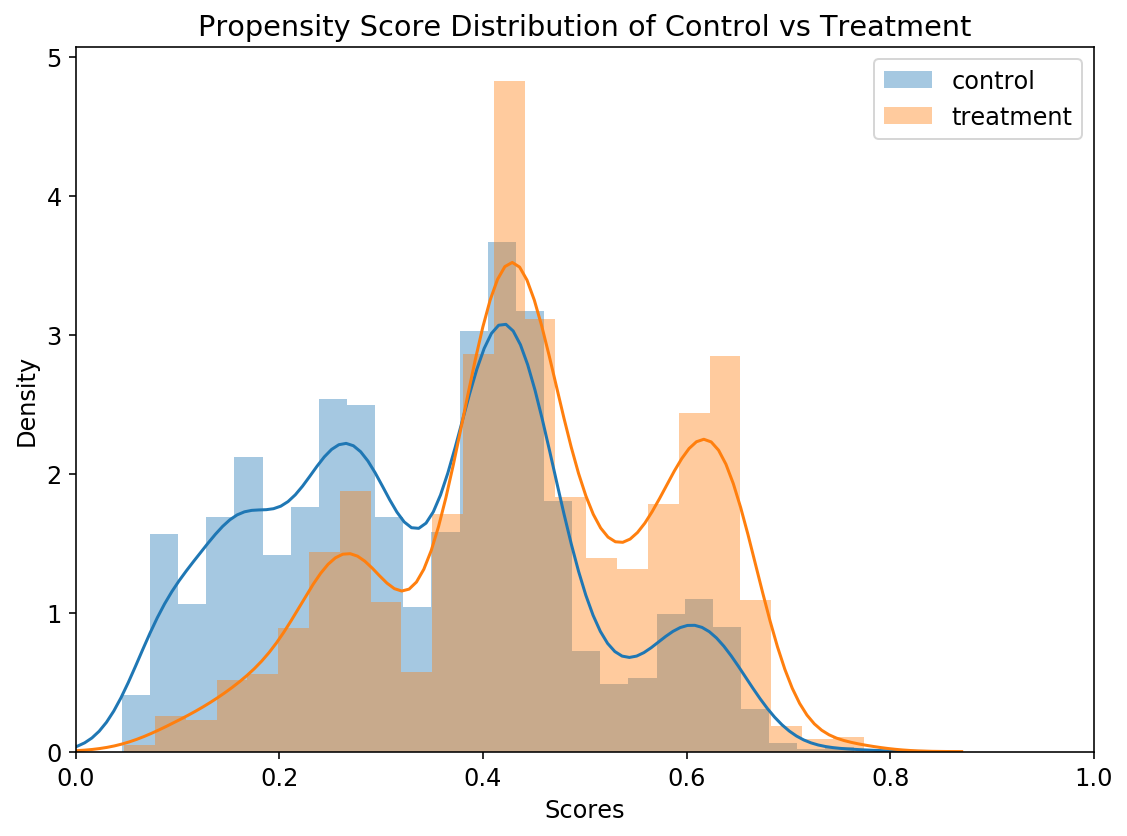

In [15]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

Keep in mind that not every plot will look like this, if there's major lack of overlap in some part of the propensity score distribution plot that means our positivity assumption would essentially be violated. Or in other words, we can't really estimate a causal effect in those area of the distribution since in those areas, those are subjects that have close to zero chance of being in the control/treatment group. One thing that we may wish to do when encountered with this scenario is either look and see if we're missing some covariates or get rid of individuals who have extreme propensity scores and focus on the areas where there are strong overlapping.

The next step is to perform matching. In general, the procedure looks like this:

> We compute the distance between the estimated propensity score for each treated subject with every control. And for every treated subject we would find the subject in the control that has the closest distance to it. These pairs are "matched" together and will be included in the final dataset that will be used to estimate the causal effect.

But in practice there are actually many different variants to performing the step mentioned above. e.g.

First: We mentioned that when there's a lack of balance, we can get rid of individuals who have extreme propensity scores. Some example of doing this includes removing control subjects whose propensity score is less than the minimum in the treatment group and removing treated subjects whose propensity score is greater than the maximum in the control group.

Second: Some people would only consider the treatment and control subject to be a match if the difference between their propensity score difference is less than a specified threshold, $\delta$ (this threshold is also referred to as caliper). In other words, given a user in the treatment group, $u_t$, we find the set of candidate matches from the control group.

\begin{align}
C(u_t) = \{ u_c \in {\text control} : |\pi_{u_c} - \pi_{u_t}| \leq \delta \}
\end{align}

If $|C(u_t)| = 0$, $u_t$ is not matched, and is excluded from further consideration. Otherwise, we select the control user $u_c$ satisfying:

\begin{align}
\text{argmin}_{u_c \in C(u_t)} \big|\pi_{u_c} - \pi_{u_t}\big|
\end{align}

and retain the pair of users. Reducing the $\delta$ parameter improves the balance of the final dataset at the cost of reducing its size, we can experiment with different values and see if we retain the majority of the test group.

Third: A single user in the control group can potentially be matched to multiple users in the treatment group. To account for this, we can add a weighting to each matched record with the inverse of its frequency. i.e. if a control group user occurred 4 times in the matched dataset, we assigned that record a weight of 1/4. We may wish to check whether duplicates occurs a lot in the final matched dataset. Some implementation gives a flag whether this multiple matched control group scenario is allowed, i.e. whether matching with replacement is allowed. If replacement is not allowed, then matches generally will be found in the same order as the data are sorted. Thus, the match(es) for the first observation will be found first, the match(es) for the second observation will be found second, etc. Matching without replacement will generally increase bias.

Here, we'll what we'll do is: for every record in the treatment we find its closest record in the control group without controlling for distance threshold and duplicates.

In [16]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[1703],
       [1329],
       [2782],
       ...,
       [1728],
       [1909],
       [2546]])

We can still check the number of occurrences for the matched control record. As mentioned in the previous section, we can add these information as weights to our dataset, but we won't be doing that here.

In [17]:
_, counts = np.unique(sim_indices[:, 0], return_counts=True)
np.bincount(counts)

array([  0, 810, 309, 121,  47,  12,   6,   7,   3,   4])

After applying the matching procedure, it's important to check and validate that the matched dataset are indeed indistinguishable in terms of the covariates that we were using to balance the control and treatment group.

In [18]:
df_cleaned[TREATMENT] = treatment
df_cleaned[DEATH] = death
df_pos = df_cleaned[mask]
df_neg = df_cleaned[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1
9,48.42398,73.0,0,0,0,0,0,0,0,0,0,1,0
11,68.34796,50.0,0,0,0,0,0,0,0,0,1,1,0


In [19]:
table_one_matched = df_matched.groupby(TREATMENT).agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched)
table_one_smd_matched

,features,smd
0,age,0.0160
1,meanbp1,0.0072
2,cat1_chf,0.0184
3,cat1_cirrhosis,0.0091
4,cat1_colon_cancer,0.0707
5,cat1_coma,0.0091
6,cat1_copd,0.0557
7,cat1_lung_cancer,0.0626
8,cat1_mosf,0.0035
9,cat1_mosf_sepsis,0.0039


Upon completing propensity score matching and verified that our covariates are now fairly balanced using standardized mean difference (smd), we can carry out a outcome analysis using a paired t-test. For all the various knobs that we've described when introducing the matching process, we can experiment with various options and see if our conclusions change.

In [20]:
num_matched_pairs = df_neg.shape[0]
print('number of matched pairs: ', num_matched_pairs)

# pair t-test
stats.ttest_rel(df_pos[DEATH].values, df_neg[DEATH].values)

number of matched pairs:  2184


Ttest_relResult(statistic=2.98993204105555, pvalue=0.0028215776367738962)

This result tells us after using matching adjustment to ensure comparability between the treatment and control group, we find that receiving Right Heart Catheterization does have an effect on a patient's chance of dying.

# Reference

- [Blog: Comparative Statistics in Python using SciPy](http://benalexkeen.com/comparative-statistics-in-python-using-scipy/)
- [Cousera: A Crash Course in Causality - Inferring Causal Effects from Observational Data](https://www.coursera.org/learn/crash-course-in-causality/)
- [Github: pymatch - Matching techniques for observational studies](https://github.com/benmiroglio/pymatch)
- [Paper: B. Miroglio, D. Zeber, J. Kaye, R. Weiss - The Effect of Ad Blocking on User Engagement with the Web (2018)](https://dl.acm.org/citation.cfm?id=3178876.3186162)